In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import string
import pandas as pd
import jinja2

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

pd.options.mode.chained_assignment = None #chained assignments are not flagged

In [6]:
movies2 = pd.read_csv("movies2.csv")

In [7]:
movies2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7643 entries, 0 to 7642
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7643 non-null   object 
 1   rating    7575 non-null   object 
 2   genre     7643 non-null   object 
 3   year      7643 non-null   int64  
 4   score     7643 non-null   float64
 5   director  7643 non-null   object 
 6   country   7643 non-null   object 
 7   budget    5484 non-null   float64
 8   gross     7466 non-null   float64
 9   company   7632 non-null   object 
 10  runtime   7643 non-null   float64
 11  date      7643 non-null   object 
dtypes: float64(4), int64(1), object(7)
memory usage: 716.7+ KB


In [8]:
movies2.isnull().sum().sort_values(ascending=False)

budget      2159
gross        177
rating        68
company       11
name           0
genre          0
year           0
score          0
director       0
country        0
runtime        0
date           0
dtype: int64

## Scaling

In [13]:
ndf = movies2[['score', 'runtime', 'gross']].dropna()
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7466 entries, 0 to 7642
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   score    7466 non-null   float64
 1   runtime  7466 non-null   float64
 2   gross    7466 non-null   float64
dtypes: float64(3)
memory usage: 233.3 KB


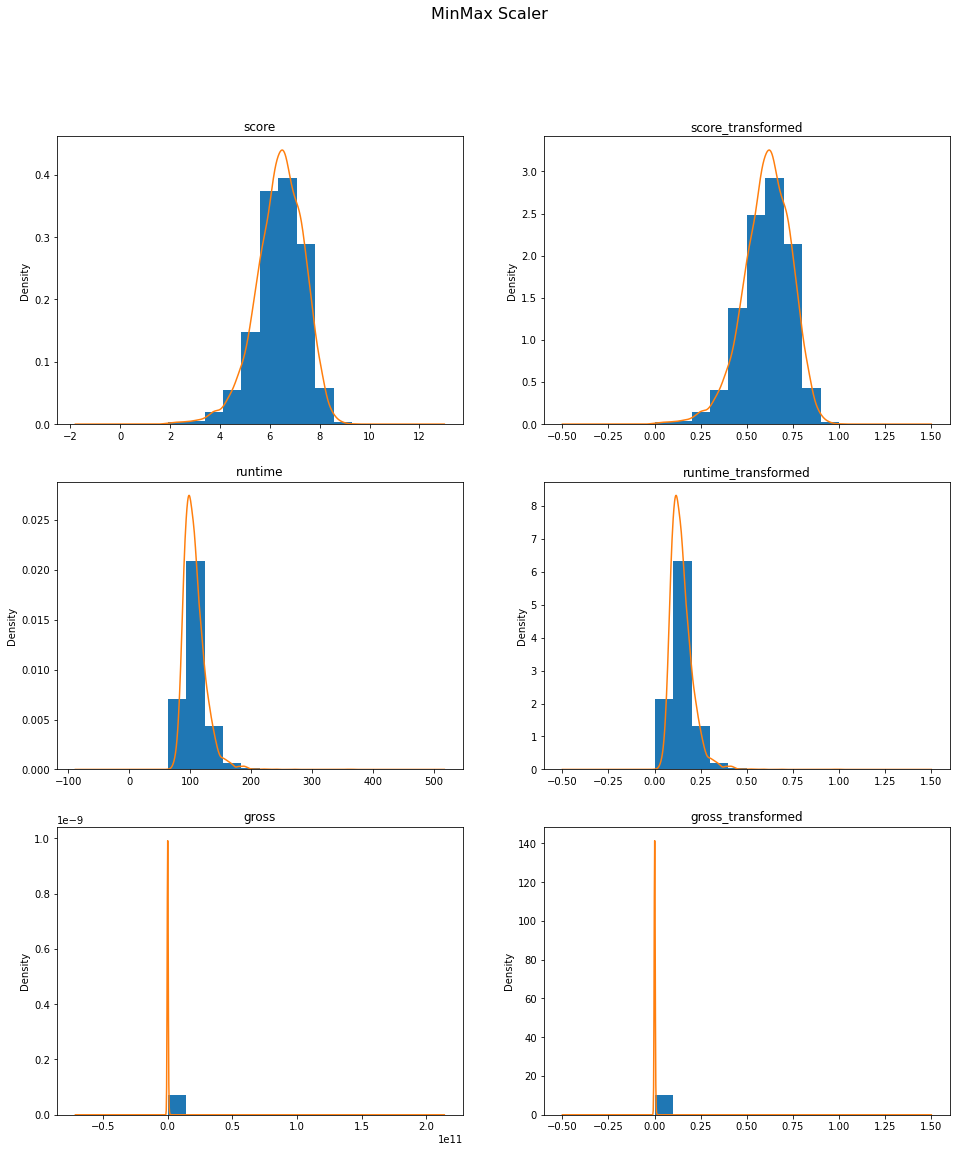

In [12]:
#The function plots graphs in a grid whose dimentions are 2 x (number of attributes).
#A row in the grid consits of two sets of axes. The first set of axes has a histogram of an numeric
#attribute, along with its density function. The second set of axes consists of a histogram
#and density plot of a normalized version of the attribute. The method of normalization is set outsite
#the function.

# @df is the dataframe with numeric attributes 
# @columns is an array with the names of columns in the df
# @df_transformed is a dataframe with normalized attributes of df
# @fit_title is the overall title of all the plots

def density_plots(df, columns, df_transformed, fig_title, constrained_layout=True):
    fig, axs = plt.subplots(len(columns),2,figsize=(16,18))
    fig.suptitle(fig_title, fontsize=16)
    axs = axs.flatten()
    i = 0 
    for c in columns:
        ndf[c].hist(ax=axs[i], density=True) # normalizes the density
        ndf[c].plot.density(ax=axs[i], title=c)
        df_transformed[c].hist(ax=axs[i+1], density=True, stacked=True) # normalizes the density
        df_transformed[c].plot.density(ax=axs[i+1], title=str(c+'_transformed'))
        i+=2

val_cols_names = ['score','runtime','gross']

scaler = MinMaxScaler()
min_max_tdf = scaler.fit_transform(ndf)
min_max_tdf = pd.DataFrame(min_max_tdf, index=ndf.index, columns=ndf.columns)

density_plots(ndf, val_cols_names, min_max_tdf, 'MinMax Scaler')